## Chronology-controlled experiments

We clearly see in general semantic halo model, that similarities/dissimilarties between meters are at least partly driven by chronolgy. We have ~200 years of Russian poetry, and themes are not equally distributed over this time, they emerge and dissappear, 19th language is easily distinguishable from 20th century language and model exploits it.

To control for chronology, we built another topic model using only 19th century texts, which had date of creation annotations. 

In [3]:
### load libraries & data
#core
library(topicmodels)
library(tidytext)
library(tidyverse)
library(stringi)
#calculations
library(philentropy)
library(mclust)
library(NMF)
#trees
library(ggtree)
library(ape)
library(phylogram)

#visuals
library(paletteer)
library(hrbrthemes)
library(DT)


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Package 'mclust' version 5.4.6
Type 'citation("mclust")' for citing this R package in publications.


Attaching package: ‘mclust’


The following object is masked from ‘package:purrr’:

    map


Loading required package: pkgmaker

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 7/8

  To enable shared memory capabilities, try: install.extras('
NMF
')

Registered S3 method overwritten by 'treeio':
  method     from
  root.phylo ape 

ggtree v2.2.4  For help: https://y

## 0. Preparations


In [4]:
## set years of period span 
period_span = 30

In [6]:
load("data/lda_output.rda")
#drop NA poems


### pull list of unique poems for later sampling

unique_poems_period = unique_poems  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1740)  %>% 
    mutate(period = case_when(period < 1800 ~ 1770,
                              TRUE ~ period))
 #   mutate(chunk = id,
 #          id = chunk,
 #          id = str_replace_all(id, "-.*", ""))



### get count of meters
meter_counts_period = unique_poems  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1740)  %>% 
    mutate(period = case_when(period < 1800 ~ 1770,
                              TRUE ~ period))  %>% 

    count(meter,period,  sort=T)  %>% 
    filter(!str_detect(meter,"NA"))


### get count of metrical forms (meter + clausula)
meter_claus_period = unique_poems_period  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1740)  %>% 
    mutate(period = case_when(period < 1800 ~ 1770,
                              TRUE ~ period))  %>% 
    filter(!str_detect(meter,"NA_"))


head(unique_poems_period)
head(ru_gamma_separated)
head(meter_claus_period)
head(meter_counts_period)


id,author,year,meter,clausula,period
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,В.И.Майков,1767,Явольн,вольн,1770
2,В.И.Майков,1767,Я6,жжмм,1770
3,В.И.Майков,1767,Явольн,вольн,1770
4,В.И.Майков,1773,Х4,мж,1770
5,В.И.Майков,1767,Я6,"ж,м",1770
6,В.И.Майков,1777,Я6,ммжж,1770


id,author,year,meter,clausula,topic,gamma,label
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
1,В.И.Майков,1767,Явольн,вольн,1,0.014864865,1_звезда мир небо земля бездна
2,В.И.Майков,1767,Я6,жжмм,1,0.002173913,1_звезда мир небо земля бездна
3,В.И.Майков,1767,Явольн,вольн,1,0.001639344,1_звезда мир небо земля бездна
4,В.И.Майков,1773,Х4,мж,1,0.001020408,1_звезда мир небо земля бездна
5,В.И.Майков,1767,Я6,"ж,м",1,0.002173913,1_звезда мир небо земля бездна
6,В.И.Майков,1777,Я6,ммжж,1,0.070000000,1_звезда мир небо земля бездна


id,author,year,meter,clausula,period
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,В.И.Майков,1767,Явольн,вольн,1770
2,В.И.Майков,1767,Я6,жжмм,1770
3,В.И.Майков,1767,Явольн,вольн,1770
4,В.И.Майков,1773,Х4,мж,1770
5,В.И.Майков,1767,Я6,"ж,м",1770
6,В.И.Майков,1777,Я6,ммжж,1770


meter,period,n
<chr>,<dbl>,<int>
Я4,1890,3782
Я4,1920,2860
Я5,1920,2802
Я5,1890,1989
Х4,1890,1570
Х4,1920,1216


In [7]:
# top meters per periods, split
meters_in_periods = meter_counts_period  %>% 
 group_by(period)  %>% 
 top_n(6, n)  %>% 
 group_split()
meters_in_periods

meter,period,n
<chr>,<dbl>,<int>
Явольн,1770,306
Я6,1770,297
Я4,1770,192
Х4,1770,191
Я3,1770,93
С8,1770,9
Я6Я3,1770,9
meter,period,n
<chr>,<dbl>,<int>


In [9]:
source("src//test_clusters_halo.R")
source("src//poem_sampler.R")

slide_df=c()
periods= meter_counts_period  %>% select(period) %>% arrange(period) %>% unique()  %>% pull()
periods=periods[-1] # remove 18th century

for (i in 1:length(periods)) {

meters_per_i = meter_counts_period  %>% filter(period==periods[i])  %>% top_n(6,n)

halo_clusters = test_clusters_halo(poem_list=unique_poems_period %>% filter(period==periods[i]),
                                   meter_list=meters_per_i,
                         p_size=floor(min(meters_per_i$n)/20)*10,
                         samples_per_meter=2,
                         iterations=100,
                         min_meter_count=-Inf,
                         max_meter_count=Inf,
                         rep=FALSE,
                         clust_method = "complete",
                         dist="JSD")  %>% 
    select(-poems_per_sample)  %>% 
    mutate(window_start=periods[i])

slide_df = slide_df  %>% bind_rows(halo_clusters)

}


[1] "Now at 30 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 50 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 30 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 14 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 270 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 250 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

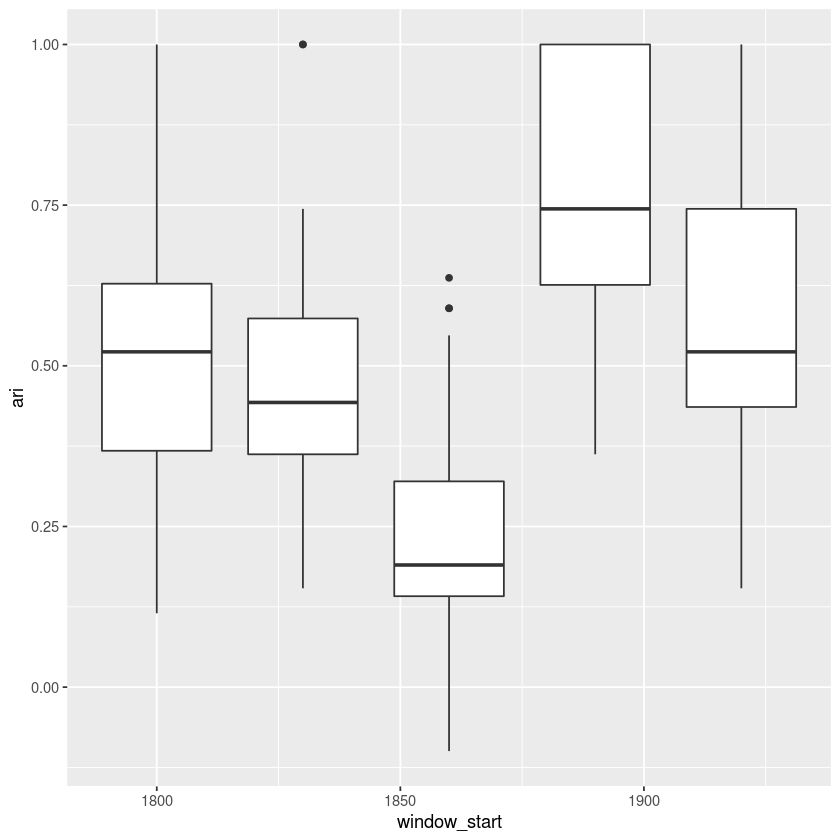

In [10]:
slide_df  %>% ggplot(aes(window_start, ari, group=window_start)) + geom_boxplot()

In [12]:
slide_df  %>% group_by(window_start)  %>% summarise(m_ari = mean(ari), .groups="keep")

window_start,m_ari
<dbl>,<dbl>
1800,0.5144077
1830,0.4743685
1860,0.2322051
1890,0.7711014
1920,0.5813450


## Two halves of an apple (1800-1850 vs. 1850-1900)

### Recalculate data for 50-year spans

In [13]:
## set years of period span 
period_span = 50

In [14]:
load("data/lda_output.rda")
#drop NA poems


### pull list of unique poems for later sampling

unique_poems_period = unique_poems  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1800 & period < 1900) 
   #   mutate(chunk = id,
 #          id = chunk,
 #          id = str_replace_all(id, "-.*", ""))



### get count of meters
meter_counts_period = unique_poems  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1800 & period < 1900)  %>% 
  
    count(meter,period,  sort=T)  %>% 
    filter(!str_detect(meter,"NA"))


### get count of metrical forms (meter + clausula)
meter_claus_period = unique_poems_period  %>% 
    mutate(period = floor(as.numeric(year)/period_span)*period_span)  %>% 
    filter(period >= 1800 & period < 1900)  %>%
    filter(!str_detect(meter,"NA_"))


unique_poems_period
head(ru_gamma_separated)
head(meter_claus_period)
head(meter_counts_period)


id,author,year,meter,clausula,period
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
59,М.Н.Муравьев,1802,Я6,мж,1800
74,М.Н.Муравьев,1802,Я3,ммж,1800
80,М.Н.Муравьев,1802,Я6,жм,1800
139,М.Н.Муравьев,1804,Х4жмХ3ж,Х4жм Х3ж,1800
443,Ю.А.Нелединский-Мелецкий,1808,Я4,жм,1800
464,Ю.А.Нелединский-Мелецкий,1808,Явольн,вольн,1800
466,Ю.А.Нелединский-Мелецкий,1808,Х4,"ж,м",1800
471,П.А.Пельский,1803,Х4,жм,1800
479,П.А.Пельский,1803,Я4,"ж,м",1800


id,author,year,meter,clausula,topic,gamma,label
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>
1,В.И.Майков,1767,Явольн,вольн,1,0.014864865,1_звезда мир небо земля бездна
2,В.И.Майков,1767,Я6,жжмм,1,0.002173913,1_звезда мир небо земля бездна
3,В.И.Майков,1767,Явольн,вольн,1,0.001639344,1_звезда мир небо земля бездна
4,В.И.Майков,1773,Х4,мж,1,0.001020408,1_звезда мир небо земля бездна
5,В.И.Майков,1767,Я6,"ж,м",1,0.002173913,1_звезда мир небо земля бездна
6,В.И.Майков,1777,Я6,ммжж,1,0.070000000,1_звезда мир небо земля бездна


id,author,year,meter,clausula,period
<int>,<chr>,<chr>,<chr>,<chr>,<dbl>
59,М.Н.Муравьев,1802,Я6,мж,1800
74,М.Н.Муравьев,1802,Я3,ммж,1800
80,М.Н.Муравьев,1802,Я6,жм,1800
139,М.Н.Муравьев,1804,Х4жмХ3ж,Х4жм Х3ж,1800
443,Ю.А.Нелединский-Мелецкий,1808,Я4,жм,1800
464,Ю.А.Нелединский-Мелецкий,1808,Явольн,вольн,1800


ERROR: Error in head(meter_count_period): object 'meter_count_period' not found


### Determine eligible meters shared across periods

In [15]:
meters_in_periods = meter_counts_period  %>% 
 group_by(period)  %>% 
 top_n(10, n)  %>% 
 filter(n > 80)  %>% 
 group_split()
meters_in_periods

meter,period,n
<chr>,<dbl>,<int>
Я4,1800,1483
Х4,1800,649
Явольн,1800,610
Я6,1800,366
Я5,1800,321
Я3,1800,113
Аф4,1800,88
meter,period,n
<chr>,<dbl>,<int>


In [16]:
eligible_meters = intersect(meters_in_periods[[1]]$meter, meters_in_periods[[2]]$meter)


meter_count_rolling = meter_counts_period  %>% 
    filter(meter %in% eligible_meters)  %>% 
    group_by(meter)  %>% 
    summarise(n =sum(n))  %>% 
    ungroup()


eligible_meters

`summarise()` ungrouping output (override with `.groups` argument)



[1] "Я4"     "Х4"     "Явольн" "Я6"     "Я5"     "Аф4"

### Iterative clustering per period

In [17]:
source('src/test_clusters_halo.R')
source('src/poem_sampler.R')
slide_df = c()
periods = c(1800,1850)
for (i in 1:length(periods)) {
    

halo_clusters = test_clusters_halo(poem_list=unique_poems_period  %>% filter(period==periods[i]),
                                   meter_list=meter_count_rolling,
                         p_size=40,
                         samples_per_meter=2,
                         iterations=1000,
                         min_meter_count=-Inf,
                         max_meter_count=Inf,
                         rep=FALSE)  %>% 
    select(-poems_per_sample)  %>% 
    mutate(window_start=periods[i])

slide_df = slide_df  %>% bind_rows(halo_clusters)

}


[1] "Now at 40 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

[1] "Now at 40 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 12 vectors.

Metric: 'jensen-shannon' using uni

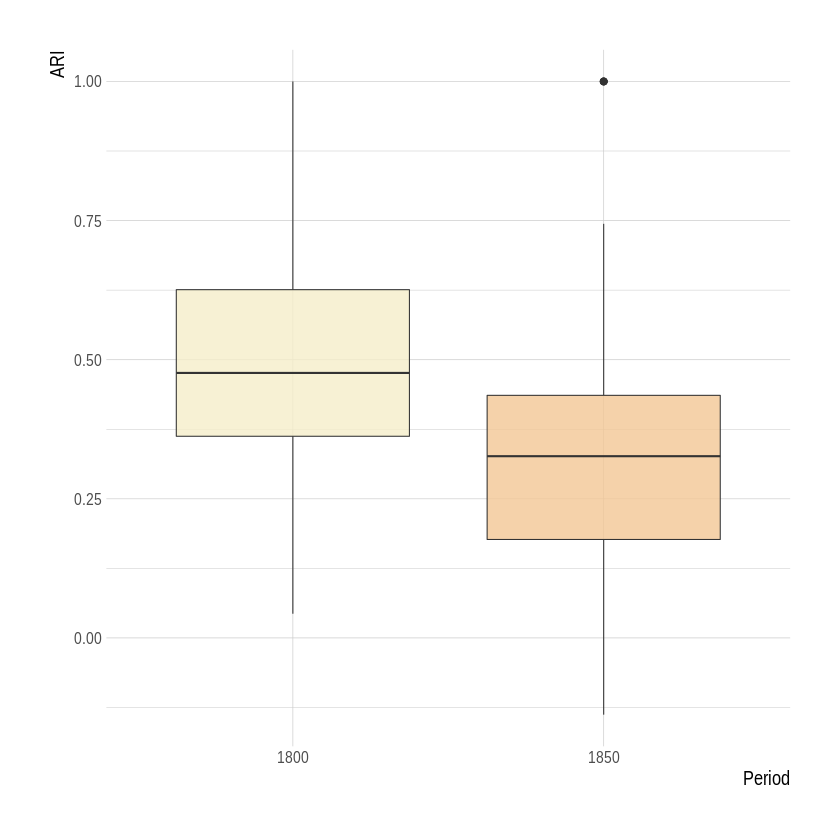

In [18]:
slide_df  %>% ggplot(aes(as.character(window_start), ari, group=window_start, fill=as.character(window_start))) + geom_boxplot(alpha=0.8,size=0.3) +
theme_ipsum() + labs(x="Period", y="ARI") + theme(axis.title.x = element_text(size=12),
                                                  axis.title.y = element_text(size=12),
                                                  axis.text.x=element_text(size=10),
                                                  axis.text.y=element_text(size=10)) + scale_fill_paletteer_d("ghibli::MononokeLight",direction = -1) + guides(fill=F)

In [9]:
ggsave("plots/fig4_periods.png", width = 6, height = 4)

In [22]:
ari_1800 = slide_df  %>% filter(window_start==1800)  %>% pull(ari)
ari_1850 = slide_df  %>% filter(window_start==1850)  %>% pull(ari)

t.test(ari_1800, ari_1850)
slide_df  %>% group_by(window_start)  %>% summarise(m_purity=median(purity), m_ari=median(ari))


	Welch Two Sample t-test

data:  ari_1800 and ari_1850
t = 19.599, df = 1977.3, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1436851 0.1756379
sample estimates:
mean of x mean of y 
0.4783203 0.3186588 


`summarise()` ungrouping output (override with `.groups` argument)



window_start,m_purity,m_ari
<dbl>,<dbl>,<dbl>
1800,0.8333333,0.4761905
1850,0.7500000,0.3265306


### Increased sample size for 1850s

In [28]:
slide_df=NULL

halo_clusters = test_clusters_halo(poem_list=unique_poems_period  %>% filter(period==periods[2]),
                                   meter_list=meter_counts_period  %>% filter(period==1850, n>=200) ,
                         p_size=100,
                         samples_per_meter=2,
                         iterations=100,
                         min_meter_count=-Inf,
                         max_meter_count=Inf,
                         rep=FALSE)  %>% 
    select(-poems_per_sample)  %>% 
    mutate(window_start=periods[i])

slide_df = slide_df  %>% bind_rows(halo_clusters)

[1] "Now at 100 poems"


Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using unit: 'log2'; comparing: 10 vectors.

Metric: 'jensen-shannon' using uni

In [29]:
slide_df  %>% group_by(window_start)  %>% summarise(m_purity=median(purity), m_ari=median(ari))

`summarise()` ungrouping output (override with `.groups` argument)



window_start,m_purity,m_ari
<dbl>,<dbl>,<dbl>
1850,0.8,0.4255319
